In [1]:
import os
import sys
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate, shift
from scipy.ndimage.morphology import binary_erosion, binary_opening, binary_closing

from skimage.measure import block_reduce

from skimage.transform import hough_line, hough_line_peaks

import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from sklearn.decomposition.pca import PCA

In [19]:
def binarize(img, thres):
    res = np.sum(img,axis=2) > thres
    return res.astype(int)

def downsample(img):
    res = block_reduce(img, block_size=(21, 21), func=np.mean)
    return res

def erode(img):
    res = binary_erosion(img, np.ones((3,3), dtype=np.int))
    return res

def find_angle(img):
    img = binarize(img, 20)
    img = erode(img)
    h_space, angles, dist = hough_line(img)
    h_space, angles, dist = hough_line_peaks(h_space, angles, dist, num_peaks=1)
    return math.degrees(angles[0])

def rotate_to_base(img):
    """
    Finds out what the asparagus angle is, zeroes image by rotating it to 0°, then creates 
    three +/- 5° rotations of it, with noise added to the degrees by which the image is rotated
    """
    angle = find_angle(img)
    base = rotate(img, angle, reshape=False, mode="constant")
    return base


def find_bounds(img):
    """
    Finds the upper and lower limit of the nonzero box, that is: 
    Where the asparagus piece starts and where it ends.
    
    returns: upper and lower, the limits
    """
    img = np.array(img)
    img = binarize(img, 20)
    
    collapse = np.sum(img, axis=1)
    nonz = np.nonzero(collapse)
    
    upper = nonz[0][0]
    lower = nonz[0][-1]
        
    return upper, lower


def get_length(img):
    '''Simple length extraction
    The length is measured from the highest white pixel to the lowest in the binarized image after rotation
    Args:
        img: the image
    Returns:
        length: the length in pixels from highest to lowest point
    '''
    img = rotate_to_base(img)
    upper, lower = find_bounds(img)
    length = lower - upper

    return length / 4.5


def get_horizontal_slices(img, k):
    """
    Calculates the x-coordinates of the outline of the asparagus pieces, measured at k evenly
    spaced horizontal slicing points.

    img = the preprocessed image
    k = the number of slices

    returns: an np array([a1, a2],[b1,b2] ... ) where a1,a2 = x-coordinates of asparagus outline
    """

    upper, lower = find_bounds(img)
    slice_points = np.floor(np.linspace(upper+50, lower-20, k))
    
    def slice_img(img, sp):
        sp = int(sp)
        bin_img = binarize(img, 20)
        line = np.nonzero(bin_img[sp,:])
        left = line[0][0]
        right = line[0][-1]
        return left, right
    
    return np.array([[left, right] for left, right in [slice_img(img, sp) for sp in slice_points]])


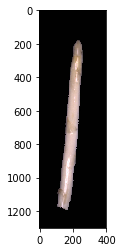

[[203 257]
 [178 247]
 [157 234]
 [135 209]
 [108 177]]


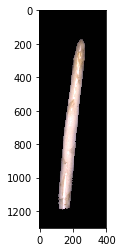

[[222 276]
 [187 253]
 [152 228]
 [131 205]
 [117 187]]


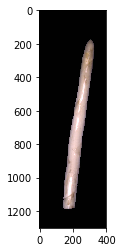

[[274 330]
 [234 301]
 [192 270]
 [165 240]
 [143 214]]


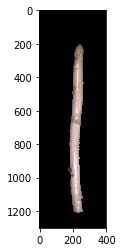

[[211 265]
 [199 261]
 [182 241]
 [174 243]
 [203 259]]


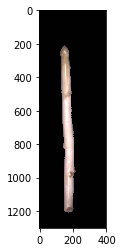

[[127 181]
 [133 194]
 [145 205]
 [150 216]
 [149 205]]


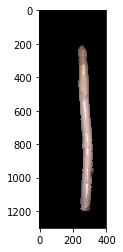

[[230 287]
 [239 299]
 [253 315]
 [260 328]
 [248 307]]


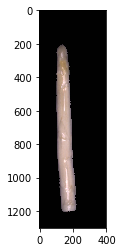

[[105 170]
 [104 184]
 [109 198]
 [115 204]
 [133 217]]


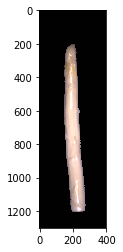

[[159 223]
 [153 231]
 [155 243]
 [172 261]
 [193 276]]


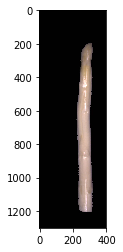

[[254 320]
 [239 313]
 [227 309]
 [237 313]
 [240 318]]


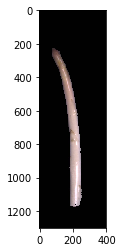

[[ 78 131]
 [150 206]
 [179 237]
 [184 248]
 [187 242]]


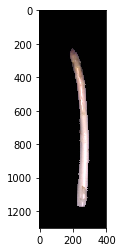

[[184 235]
 [231 280]
 [241 293]
 [241 292]
 [228 279]]


KeyboardInterrupt: 

In [21]:
img_dir ="../../images/test/"
for subdir, dirs, files in os.walk(img_dir):
    for file in sorted([f for f in files if f[-4:]==".jpg"]):
        img = plt.imread(os.path.join(subdir, file))
        plt.imshow(img)
        plt.show()
        print(get_horizontal_slices(img, 5))

In [10]:
print(np.nonzero([0,0,0,0,4,56,4,6,0,0,0]))

(array([4, 5, 6, 7]),)
